In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import shap

import xgboost as xgb
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_score, recall_score, average_precision_score,
                             PrecisionRecallDisplay, make_scorer)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.inspection import permutation_importance
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import pearsonr

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


In [10]:
def load_occupancy_data(filename="../data/occupancy_full.csv"):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"Error: '{filename}' not found.")
    df = pd.read_csv(filename)
    if 'date' in df.columns: df['date'] = pd.to_datetime(df['date'])

    num_cols = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']
    for col in [c for c in num_cols if c in df.columns]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    if 'Occupancy' in df.columns: df = df.dropna(subset=['Occupancy'])
    return df

def run_eda(df):
    print("=== Basic Info of Data ===")
    print(df.info())
    print(df.describe())
    if 'Occupancy' in df.columns:
        print("\nClass distribution:\n", df['Occupancy'].value_counts(normalize=True))

    if 'Occupancy' in df.columns:
        plt.figure(figsize=(5,4))
        sns.countplot(x='Occupancy', data=df, palette="Set2")
        plt.title("Occupancy Distribution (0=Empty, 1=Occupied)")
        plt.show()

    features = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

    for col in features:
        if col in df.columns and 'Occupancy' in df.columns:
            plt.figure(figsize=(6, 4))
            sns.violinplot(x='Occupancy', y=col, data=df, palette="Set3", inner="quartile")
            plt.title(f"{col} Distribution by Occupancy")
            plt.show()

    for col in features:
        if col in df.columns and 'Occupancy' in df.columns:
            plt.figure(figsize=(6, 4))
            sns.kdeplot(data=df, x=col, hue="Occupancy", fill=True, common_norm=False, alpha=0.5)
            plt.title(f"Distribution of {col} by Occupancy")
            plt.show()

    plt.figure(figsize=(8, 6))
    cols_to_corr = df.drop(columns=['date']) if 'date' in df.columns else df
    cols_to_corr = cols_to_corr.select_dtypes(include=[np.number])
    corr = cols_to_corr.corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()

    if 'date' in df.columns and 'Occupancy' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df['hour'] = df['date'].dt.hour
        hourly_occ = df.groupby('hour')['Occupancy'].mean()

        plt.figure(figsize=(8,5))
        plt.plot(hourly_occ.index, hourly_occ.values, marker='o')
        plt.title("Average Occupancy by Hour of Day")
        plt.xlabel("Hour of Day (0–23)")
        plt.ylabel("Average Occupancy (0~1)")
        plt.xticks(range(0,24))
        plt.grid(True)
        plt.show()

def plot_custom_autocorr_with_marks(series, max_lag=4000, freq_label="minutes"):
    series = series.reset_index(drop=True)
    lags = np.arange(max_lag)
    corr_coefs = np.zeros(max_lag)

    for i in range(1, max_lag):
        x = series.iloc[i:].reset_index(drop=True)
        y = series.iloc[:-i].reset_index(drop=True)
        corr_coefs[i] = x.corr(y, method="pearson")

    plt.figure(figsize=(10,5))
    plt.plot(lags, corr_coefs, color="steelblue", linewidth=1.5)
    plt.ylim([-1,1])
    plt.xlabel(f"Lag ({freq_label})")
    plt.ylabel("Pearson Correlation")
    plt.title("Custom Autocorrelation of Occupancy")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.axvline(x=1440, color="red", linestyle="--", label="1 day lag")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_temporal_autocorrelations(df):
    features = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']
    short_term_lags = [1, 5, 10, 30, 60]
    corr_matrix = pd.DataFrame(index=features, columns=short_term_lags, dtype=float)

    for feature in features:
        if feature in df.columns:
            for lag in short_term_lags:
                corr_matrix.loc[feature, lag] = df[feature].corr(df[feature].shift(lag))

    daily_corr = pd.Series(dtype=float)
    for feature in features:
        if feature in df.columns:
            daily_corr.loc[feature] = df[feature].corr(df[feature].shift(1440))

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    plt.subplots_adjust(wspace=0.3)
    sns.heatmap(corr_matrix, annot=True, cmap="Reds", fmt=".2f", ax=axes[0])
    axes[0].set_title("Short-term Temporal Correlation")
    sns.barplot(x=daily_corr.index, y=daily_corr.values, ax=axes[1], palette="viridis")
    axes[1].set_title("Daily repetition: corr(current, previous day)")
    plt.show()

In [11]:
def preprocess_data_windowed(df):
    df = df.copy()
    if 'date' in df.columns:
        df = df.sort_values('date').reset_index(drop=True)
        df['hour'] = df['date'].dt.hour
        df['dayofweek'] = df['date'].dt.dayofweek
        df['time_diff_min'] = df['date'].diff().dt.total_seconds() / 60.0
        gap_threshold = 60 
        df['segment'] = (df['time_diff_min'] > gap_threshold).cumsum()
    else:
        df['hour'] = 0
        df['dayofweek'] = 0
        df['segment'] = 0

    sensor_cols = ['Temperature', 'Light', 'CO2', 'HumidityRatio']
    
    gap_minutes = 30 
    window_size = 30 
    lags = range(gap_minutes, gap_minutes + window_size + 1, 5) 

    feature_cols = []

    for col in sensor_cols:
        if col not in df.columns:
            continue
        
        grp = df.groupby('segment')[col]

        mean_name = f"{col}_Mean_60to30"
        std_name  = f"{col}_Std_60to30"

        df[mean_name] = grp.transform(
            lambda s: s.shift(gap_minutes).rolling(window_size, min_periods=window_size).mean()
        )
        df[std_name] = grp.transform(
            lambda s: s.shift(gap_minutes).rolling(window_size, min_periods=window_size).std()
        )

        feature_cols.extend([mean_name, std_name])

        for lag in lags:
            lag_name = f"{col}_lag_{lag}"
            df[lag_name] = grp.transform(lambda s, lag=lag: s.shift(lag))
            feature_cols.append(lag_name)

    feature_cols = ['hour', 'dayofweek'] + feature_cols

    if 'Occupancy' not in df.columns:
        raise ValueError("Occupancy column not found in dataframe")

    df_clean = df.dropna(subset=feature_cols + ['Occupancy']).reset_index(drop=True)

    X = df_clean[feature_cols]
    y = df_clean['Occupancy']

    return X, y


=== Basic Info of Data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           20560 non-null  datetime64[ns]
 1   Temperature    20560 non-null  float64       
 2   Humidity       20560 non-null  float64       
 3   Light          20560 non-null  float64       
 4   CO2            20560 non-null  float64       
 5   HumidityRatio  20560 non-null  float64       
 6   Occupancy      20560 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.1 MB
None
                                date   Temperature      Humidity  \
count                          20560  20560.000000  20560.000000   
mean   2015-02-10 13:42:06.146984448     20.906212     27.655925   
min              2015-02-02 14:19:00     19.000000     16.745000   
25%              2015-02-06 11:05:45     20.200000     24.500000   
50

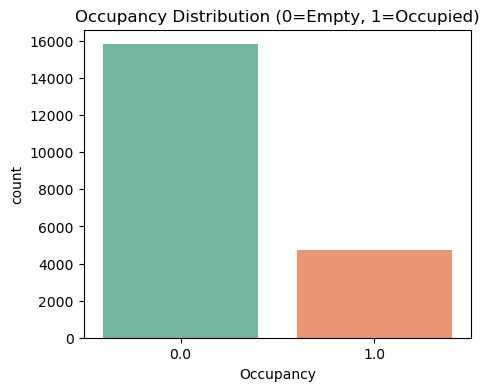

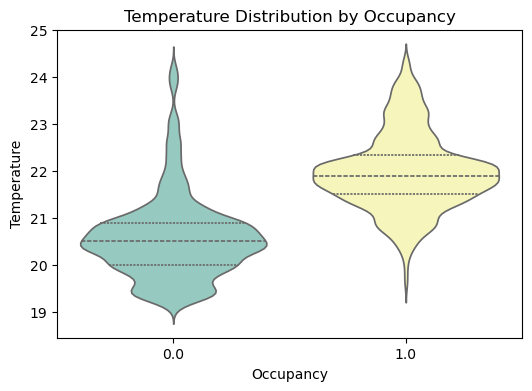

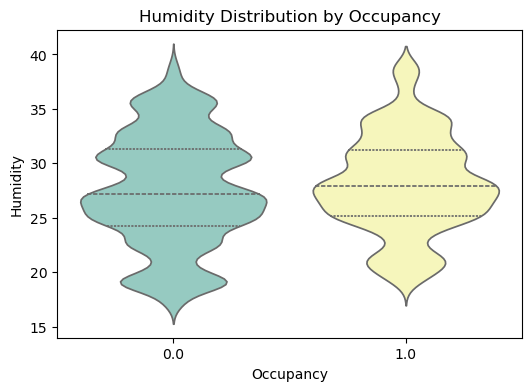

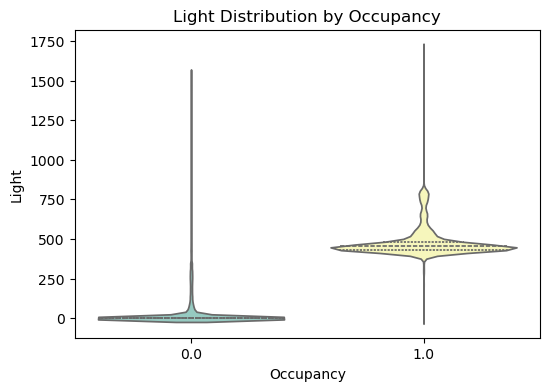

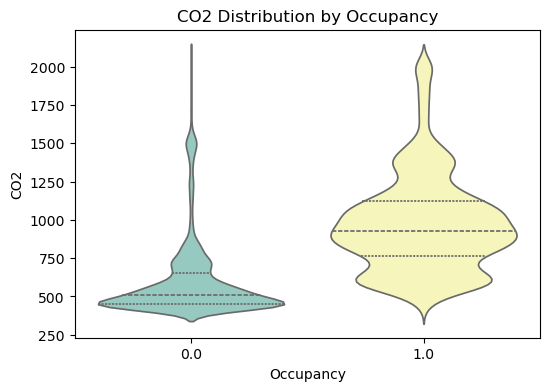

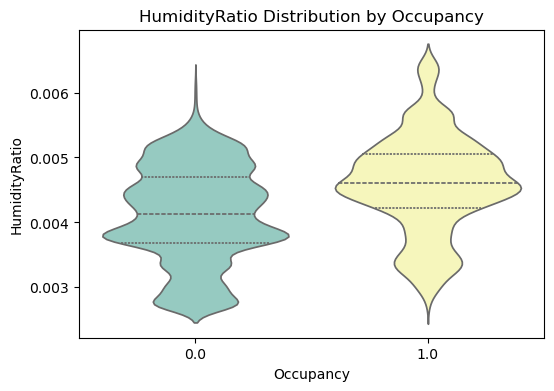

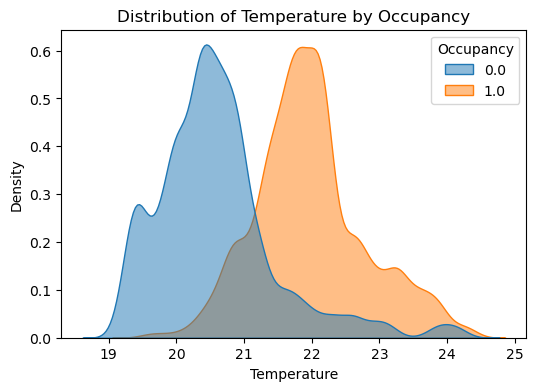

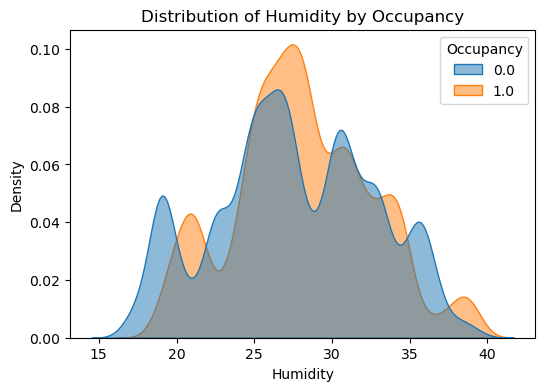

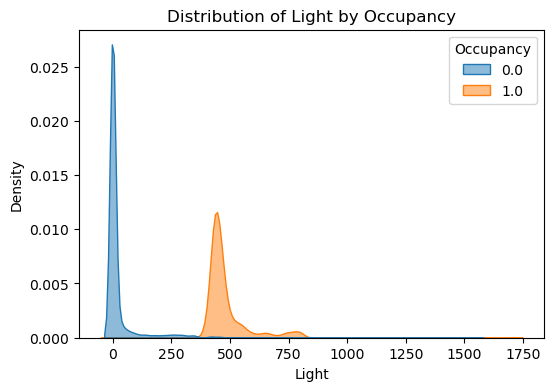

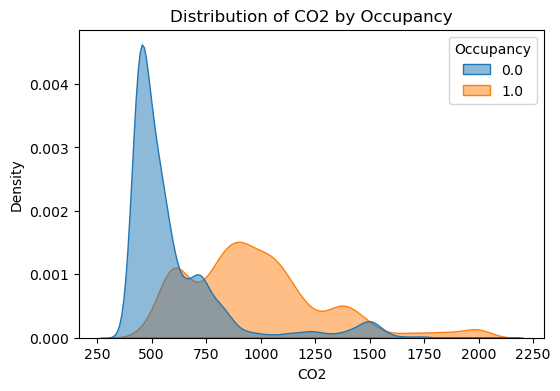

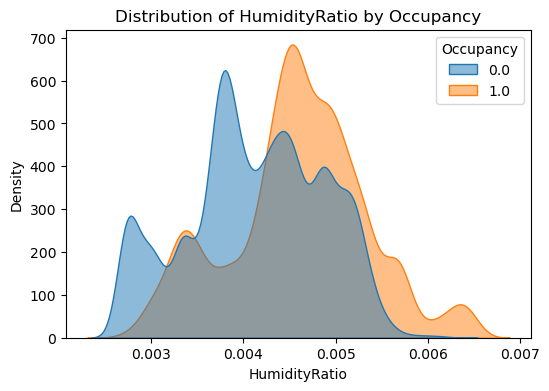

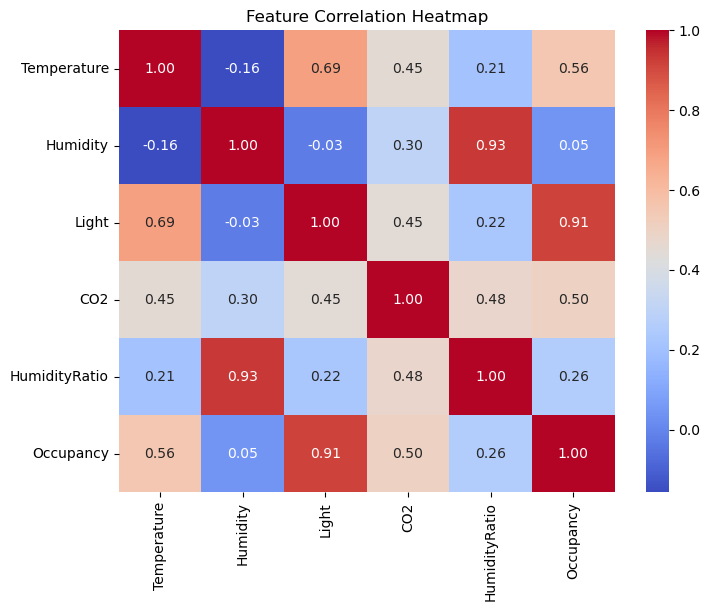

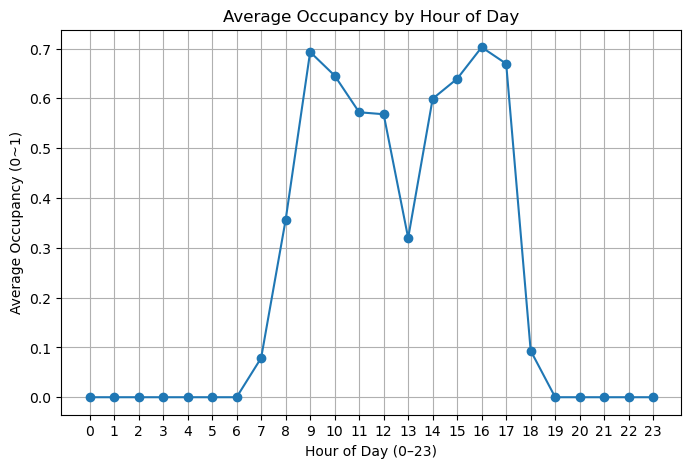

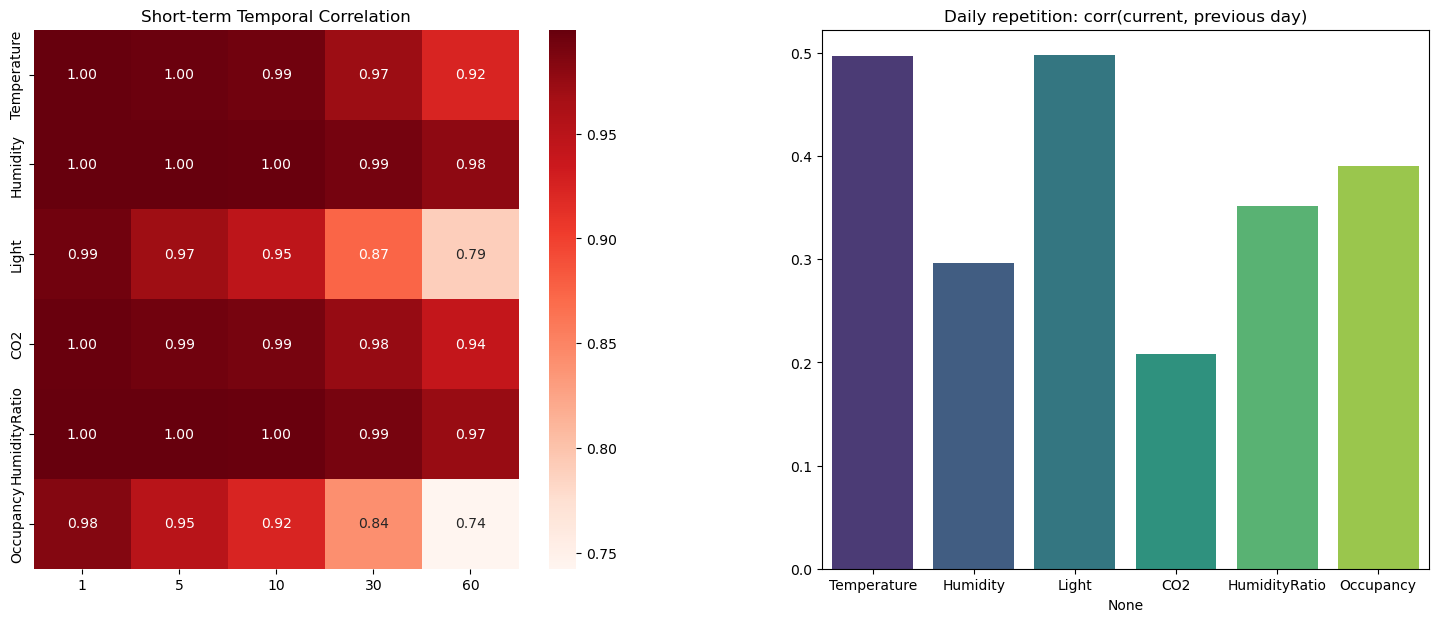

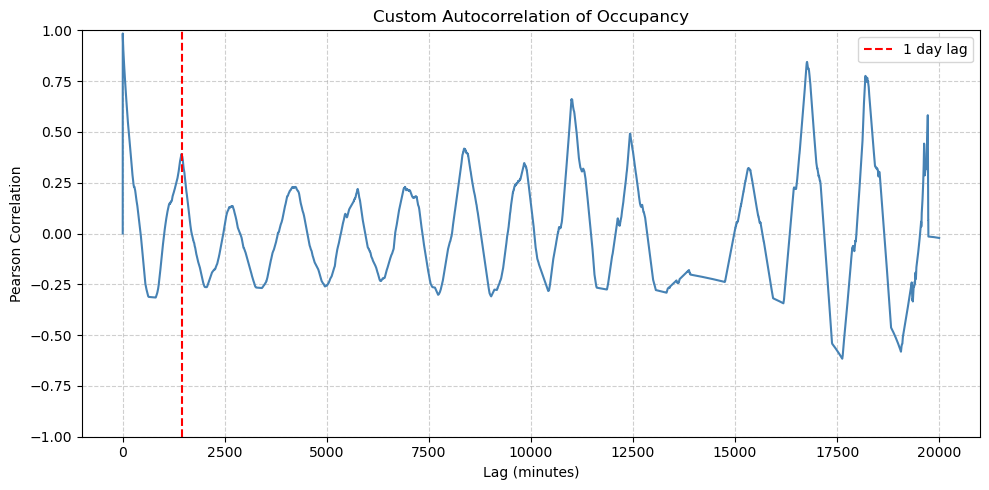


Train Size: 16304
Test Size:  4076


In [12]:
df = load_occupancy_data("../data/occupancy_full.csv")
run_eda(df)
plot_temporal_autocorrelations(df)
plot_custom_autocorr_with_marks(df['Occupancy'], max_lag=20000)
X_raw, y = preprocess_data_windowed(df)

test_ratio = 0.2
test_size = int(len(X_raw) * test_ratio)

X_train, X_test = X_raw.iloc[:-test_size], X_raw.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

print(f"\nTrain Size: {len(X_train)}")
print(f"Test Size:  {len(X_test)}")

tscv = TimeSeriesSplit(n_splits=5)

results_list = []

In [13]:
def evaluate_model(model_obj, X_train, y_train, X_test, y_test, model_name="Model"):
    print(f"\nTraining & Evaluating: {model_name}")
    start = time.time()

    if hasattr(model_obj, 'best_estimator_'):
        model = model_obj.best_estimator_
        best_cv_score = model_obj.best_score_
        print(f"Best CV F1: {best_cv_score:.4f}")
        print(f"Best Params: {model_obj.best_params_}")
    else:
        model = model_obj
        model.fit(X_train, y_train)
        best_cv_score = np.nan

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else \
             (model.decision_function(X_test) if hasattr(model, "decision_function") else y_pred)

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try: prauc = average_precision_score(y_test, y_prob)
    except: prauc = 0.0

    time_taken = time.time() - start
    print(f"Test Results -> Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | PR-AUC: {prauc:.4f}")

    results_list.append({
        "Model": model_name,
        "CV F1 (Mean)": best_cv_score,
        "Test Precision": prec,
        "Test Recall": rec,
        "Test F1": f1,
        "Test PR-AUC": prauc,
        "Time (s)": time_taken
    })
    return model

def evaluate_fitted_model(model, X_test, y_test, model_name):
    print(f"Evaluating Fitted Model: {model_name}")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_proba)
    print(f"Test Results -> Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | PR-AUC: {pr_auc:.4f}")
    
    return model

In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

print("Baseline (F1-optimal constant classifier)")

baseline = DummyClassifier(strategy='constant', constant=1)

baseline_cv_scores = cross_val_score(baseline, X_train, y_train, cv=tscv, scoring='f1', n_jobs=-1)
baseline_mean = np.mean(baseline_cv_scores)
baseline_std = np.std(baseline_cv_scores)

print(f"Baseline CV F1: {baseline_mean:.4f} +/- {baseline_std:.4f}")

baseline_model = evaluate_model(
    baseline,
    X_train, y_train,
    X_test, y_test,
    "Baseline"
)

Baseline (F1-optimal constant classifier)
Baseline CV F1: 0.2945 +/- 0.2180

Training & Evaluating: Baseline
Test Results -> Precision: 0.2691 | Recall: 1.0000 | F1: 0.4241 | PR-AUC: 0.2691


In [15]:
print("Logistic Regression Models")

def create_pipe(clf):
    return Pipeline([('scaler', StandardScaler()), ('clf', clf)])

pipe_l2 = create_pipe(LogisticRegression(penalty='l2', max_iter=5000, class_weight='balanced'))

param_l2 = {
    'clf__C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100], 
    'clf__fit_intercept': [True, False],                
    'clf__solver': ['lbfgs', 'liblinear']                
}

print(f"Tuning L2 with {len(param_l2['clf__C']) * len(param_l2['clf__fit_intercept']) * len(param_l2['clf__solver'])} combinations")
grid_l2 = GridSearchCV(pipe_l2, param_l2, cv=tscv, scoring='f1', n_jobs=-1)
grid_l2.fit(X_train, y_train)


best_idx_l2 = grid_l2.best_index_
best_mean_l2 = grid_l2.best_score_
best_std_l2 = grid_l2.cv_results_['std_test_score'][best_idx_l2]

print(f"[L2] Best Val F1: {best_mean_l2:.4f} +/- {best_std_l2:.4f}")
print(f"[L2] Best Params: {grid_l2.best_params_}")
best_l2 = evaluate_model(grid_l2, X_train, y_train, X_test, y_test, "LogReg (L2)")

pipe_l1 = create_pipe(LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000, class_weight='balanced'))

param_l1 = {
    'clf__C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
    'clf__fit_intercept': [True, False]
}

print(f"Tuning L1 with {len(param_l1['clf__C']) * len(param_l1['clf__fit_intercept'])} combinations")
grid_l1 = GridSearchCV(pipe_l1, param_l1, cv=tscv, scoring='f1', n_jobs=-1)
grid_l1.fit(X_train, y_train)

best_idx_l1 = grid_l1.best_index_
best_mean_l1 = grid_l1.best_score_
best_std_l1 = grid_l1.cv_results_['std_test_score'][best_idx_l1]

print(f"[L1] Best Val F1: {best_mean_l1:.4f} +/- {best_std_l1:.4f}")
print(f"[L1] Best Params: {grid_l1.best_params_}")
best_l1 = evaluate_model(grid_l1, X_train, y_train, X_test, y_test, "LogReg (L1)")

pipe_en = create_pipe(LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000, class_weight='balanced'))

param_en = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 
    'clf__fit_intercept': [True, False]
}

print(f"Tuning ElasticNet with {len(param_en['clf__C']) * len(param_en['clf__l1_ratio']) * len(param_en['clf__fit_intercept'])} combinations...")
grid_en = GridSearchCV(pipe_en, param_en, cv=tscv, scoring='f1', n_jobs=-1)
grid_en.fit(X_train, y_train)
best_idx_en = grid_en.best_index_
best_mean_en = grid_en.best_score_
best_std_en = grid_en.cv_results_['std_test_score'][best_idx_en]
print(f"[EN] Best Val F1: {best_mean_en:.4f} +/- {best_std_en:.4f}")
print(f"[EN] Best Params: {grid_en.best_params_}")
best_en = evaluate_model(grid_en, X_train, y_train, X_test, y_test, "LogReg (ElasticNet)")

Logistic Regression Models
Tuning L2 with 36 combinations
[L2] Best Val F1: 0.7146 +/- 0.3027
[L2] Best Params: {'clf__C': 0.1, 'clf__fit_intercept': True, 'clf__solver': 'lbfgs'}

Training & Evaluating: LogReg (L2)
Best CV F1: 0.7146
Best Params: {'clf__C': 0.1, 'clf__fit_intercept': True, 'clf__solver': 'lbfgs'}
Test Results -> Precision: 0.8456 | Recall: 0.9389 | F1: 0.8898 | PR-AUC: 0.8786
Tuning L1 with 18 combinations
[L1] Best Val F1: 0.7121 +/- 0.2997
[L1] Best Params: {'clf__C': 0.1, 'clf__fit_intercept': True}

Training & Evaluating: LogReg (L1)
Best CV F1: 0.7121
Best Params: {'clf__C': 0.1, 'clf__fit_intercept': True}
Test Results -> Precision: 0.8300 | Recall: 0.9344 | F1: 0.8791 | PR-AUC: 0.8686
Tuning ElasticNet with 40 combinations...
[EN] Best Val F1: 0.7150 +/- 0.3032
[EN] Best Params: {'clf__C': 0.1, 'clf__fit_intercept': True, 'clf__l1_ratio': 0.1}

Training & Evaluating: LogReg (ElasticNet)
Best CV F1: 0.7150
Best Params: {'clf__C': 0.1, 'clf__fit_intercept': True,

In [16]:
print("Distance & Kernel Models")

pipe_knn = create_pipe(KNeighborsClassifier())

param_knn = {
    'clf__n_neighbors': [3, 5, 10, 15, 30, 50],
    'clf__weights': ['uniform', 'distance'],      
    'clf__p': [1, 2]                             
}

print(f"Tuning KNN with {len(param_knn['clf__n_neighbors']) * len(param_knn['clf__weights']) * len(param_knn['clf__p'])} combinations")
grid_knn = GridSearchCV(pipe_knn, param_knn, cv=tscv, scoring='f1', n_jobs=-1)
grid_knn.fit(X_train, y_train)

best_idx_knn = grid_knn.best_index_
best_mean_knn = grid_knn.best_score_
best_std_knn = grid_knn.cv_results_['std_test_score'][best_idx_knn]

print(f"[KNN] Best Val F1: {best_mean_knn:.4f} +/- {best_std_knn:.4f}")
print(f"[KNN] Best Params: {grid_knn.best_params_}")
best_knn = evaluate_model(grid_knn, X_train, y_train, X_test, y_test, "KNN")

print("\nTraining SVM")
pipe_svm = create_pipe(SVC(kernel='rbf', probability=True, class_weight='balanced'))

param_svm = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__gamma': ['scale', 'auto', 0.1, 0.01]
}

print(f"Tuning SVM with {len(param_svm['clf__C']) * len(param_svm['clf__gamma'])} combinations")
grid_svm = GridSearchCV(pipe_svm, param_svm, cv=tscv, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)


best_idx_svm = grid_svm.best_index_
best_mean_svm = grid_svm.best_score_
best_std_svm = grid_svm.cv_results_['std_test_score'][best_idx_svm]

print(f"[SVM] Best Val F1: {best_mean_svm:.4f} +/- {best_std_svm:.4f}")
print(f"[SVM] Best Params: {grid_svm.best_params_}")
best_svm = evaluate_model(grid_svm, X_train, y_train, X_test, y_test, "SVM (RBF)")

Distance & Kernel Models
Tuning KNN with 24 combinations
[KNN] Best Val F1: 0.5746 +/- 0.3092
[KNN] Best Params: {'clf__n_neighbors': 50, 'clf__p': 1, 'clf__weights': 'uniform'}

Training & Evaluating: KNN
Best CV F1: 0.5746
Best Params: {'clf__n_neighbors': 50, 'clf__p': 1, 'clf__weights': 'uniform'}
Test Results -> Precision: 0.8982 | Recall: 0.9253 | F1: 0.9115 | PR-AUC: 0.8926

Training SVM
Tuning SVM with 20 combinations
[SVM] Best Val F1: 0.6286 +/- 0.3233
[SVM] Best Params: {'clf__C': 0.1, 'clf__gamma': 0.01}

Training & Evaluating: SVM (RBF)
Best CV F1: 0.6286
Best Params: {'clf__C': 0.1, 'clf__gamma': 0.01}
Test Results -> Precision: 0.7678 | Recall: 0.9435 | F1: 0.8466 | PR-AUC: 0.9442


In [17]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

print("Tree-Based Models")

param_rf = {
'n_estimators': [100, 200, 300, 500],
'max_depth': [10, 20, 30, None],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2],
'max_features': ['sqrt'],
'class_weight': ['balanced']
}

rf_combos = len(param_rf['n_estimators']) * len(param_rf['max_depth']) * len(param_rf['min_samples_split']) * len(param_rf['min_samples_leaf'])
print(f"Tuning Random Forest with {rf_combos} combinations")
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
param_rf, cv=tscv, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_idx_rf = grid_rf.best_index_
best_mean_rf = grid_rf.best_score_
best_std_rf = grid_rf.cv_results_['std_test_score'][best_idx_rf]
print(f"[RF] Best Val F1: {best_mean_rf:.4f} +/- {best_std_rf:.4f}")
print(f"[RF] Best Params: {grid_rf.best_params_}")
best_rf = evaluate_model(grid_rf, X_train, y_train, X_test, y_test, "Random Forest")


print("\nTuning XGBoost with Early Stopping")

weight_ratio = (y_train == 0).sum() / (y_train == 1).sum()

param_xgb_search = {
    'max_depth': [3, 5, 7],             
    'learning_rate': [0.01, 0.05, 0.1], 
    'subsample': [0.8],                 
    'colsample_bytree': [0.8],          
    'scale_pos_weight': [weight_ratio]  
}

param_list = list(ParameterGrid(param_xgb_search))
print(f"Testing {len(param_list)} combinations for XGBoost")

best_xgb_score = -1
best_xgb_params = None
best_xgb_std = 0.0

for i, params in enumerate(param_list):
    cv_scores = []
    
    for train_idx, val_idx in tscv.split(X_train):
        X_tr_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        clf = xgb.XGBClassifier(
            n_estimators=1000,
            eval_metric='logloss',
            early_stopping_rounds=50,
            random_state=42,
            n_jobs=-1,
            **params
        )
        
        clf.fit(
            X_tr_fold, y_tr_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )
        
        preds = clf.predict(X_val_fold)
        cv_scores.append(f1_score(y_val_fold, preds))
    
    mean_score = np.mean(cv_scores)
    
    if mean_score > best_xgb_score:
        best_xgb_score = mean_score
        best_xgb_std = np.std(cv_scores)
        best_xgb_params = params

print(f"[XGB] Best Val F1: {best_xgb_score:.4f} +/- {best_xgb_std:.4f}")
print(f"[XGB] Best Params: {best_xgb_params}")

print("\nRetraining Final XGBoost with Best Params")

split_idx = int(len(X_train) * 0.85)
X_tr_final, X_val_final = X_train.iloc[:split_idx], X_train.iloc[split_idx:]
y_tr_final, y_val_final = y_train.iloc[:split_idx], y_train.iloc[split_idx:]

final_xgb = xgb.XGBClassifier(
    n_estimators=1000,
    eval_metric='logloss',
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1,
    **best_xgb_params
)

final_xgb.fit(
    X_tr_final, y_tr_final,
    eval_set=[(X_val_final, y_val_final)],
    verbose=False
)

print(f"Final XGBoost Best Iteration: {final_xgb.best_iteration}")

best_xgb = evaluate_fitted_model(final_xgb, X_test, y_test, "XGBoost (EarlyStopping)")

Tree-Based Models
Tuning Random Forest with 96 combinations
[RF] Best Val F1: 0.6774 +/- 0.3381
[RF] Best Params: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}

Training & Evaluating: Random Forest
Best CV F1: 0.6774
Best Params: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Test Results -> Precision: 0.9132 | Recall: 0.9590 | F1: 0.9355 | PR-AUC: 0.9541

Tuning XGBoost with Early Stopping
Testing 9 combinations for XGBoost
[XGB] Best Val F1: 0.6944 +/- 0.3400
[XGB] Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'scale_pos_weight': np.float64(3.631818181818182), 'subsample': 0.8}

Retraining Final XGBoost with Best Params
Final XGBoost Best Iteration: 359
Evaluating Fitted Model: XGBoost (EarlyStopping)
Test Results -> Precision: 0.9158 | Recall: 0.9617 | F1: 0.9382 | PR-AU


Final Model Performance Comparison


,Model,Precision,Recall,F1-Score,PR-AUC
0,XGBoost,0.9158,0.9617,0.9382,0.9362
1,Random Forest,0.9132,0.9590,0.9355,0.9541
2,KNN,0.8982,0.9253,0.9115,0.8926
3,LogReg (L2 / Ridge),0.8456,0.9389,0.8898,0.8786
4,LogReg (ElasticNet),0.8434,0.9380,0.8882,0.8781
5,LogReg (L1 / Lasso),0.8293,0.9344,0.8787,0.8686
6,SVM (RBF),0.7678,0.9435,0.8466,0.9442
7,Baseline,0.2691,1.0000,0.4241,0.2691


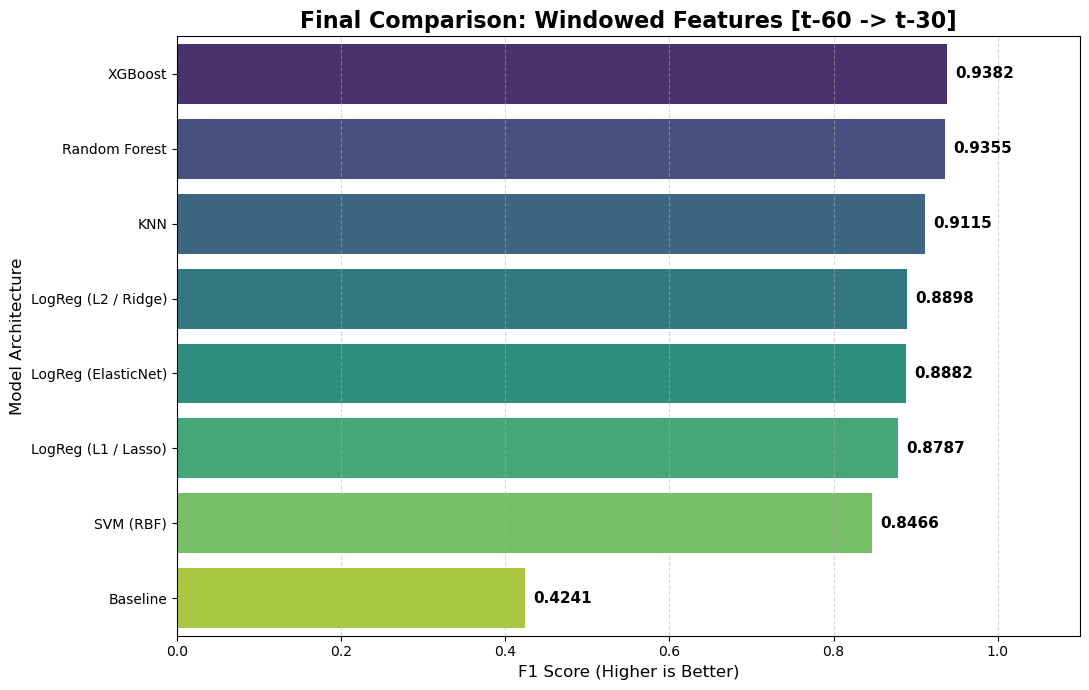

In [18]:
results_data = [
    {"Model": "XGBoost",             "Precision": 0.9158, "Recall": 0.9617, "F1-Score": 0.9382, "PR-AUC": 0.9362},
    {"Model": "Random Forest",       "Precision": 0.9132, "Recall": 0.9590, "F1-Score": 0.9355, "PR-AUC": 0.9541},
    {"Model": "KNN",                 "Precision": 0.8982, "Recall": 0.9253, "F1-Score": 0.9115, "PR-AUC": 0.8926},
    {"Model": "LogReg (L2 / Ridge)", "Precision": 0.8456, "Recall": 0.9389, "F1-Score": 0.8898, "PR-AUC": 0.8786},
    {"Model": "LogReg (ElasticNet)", "Precision": 0.8434, "Recall": 0.9380, "F1-Score": 0.8882, "PR-AUC": 0.8781},
    {"Model": "LogReg (L1 / Lasso)", "Precision": 0.8293, "Recall": 0.9344, "F1-Score": 0.8787, "PR-AUC": 0.8686},
    {"Model": "SVM (RBF)",           "Precision": 0.7678, "Recall": 0.9435, "F1-Score": 0.8466, "PR-AUC": 0.9442},
    {"Model": "Baseline",            "Precision": 0.2691, "Recall": 1.0000, "F1-Score": 0.4241, "PR-AUC": 0.2691}
]

summary_df = pd.DataFrame(results_data)
summary_df = summary_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("\nFinal Model Performance Comparison")
pd.set_option("display.precision", 4)
display(summary_df)

plt.figure(figsize=(11, 7))
barplot = sns.barplot(
    x="F1-Score",
    y="Model",
    data=summary_df,
    palette="viridis",
    hue="Model",
    legend=False,
)

for p in barplot.patches:
    width = p.get_width()
    if width > 0:
        plt.text(
            width + 0.01,
            p.get_y() + p.get_height() / 2,
            f"{width:1.4f}",
            va="center",
            fontweight="bold",
            fontsize=11,
        )

plt.title("Final Comparison: Windowed Features [t-60 -> t-30]", fontsize=16, fontweight="bold")
plt.xlabel("F1 Score (Higher is Better)", fontsize=12)
plt.ylabel("Model Architecture", fontsize=12)
plt.xlim(0, 1.1)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [27]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.dummy import DummyClassifier
import numpy as np
import xgboost as xgb

print("\nUncertainty Quantification & Baseline Comparison")

tscv = TimeSeriesSplit(n_splits=5)
baseline_model = DummyClassifier(strategy='constant', constant=1)
baseline_scores = cross_val_score(baseline_model, X_train, y_train, cv=tscv, scoring='f1', n_jobs=-1)

baseline_mean = np.mean(baseline_scores)
baseline_std = np.std(baseline_scores)
print(f"Baseline CV F1: {baseline_mean:.4f} +/- {baseline_std:.4f}")

xgb_params_fixed = best_xgb_params.copy()
xgb_params_fixed['n_estimators'] = final_xgb.best_iteration
print(f"Using fixed params for uncertainty check: {xgb_params_fixed}")


def measure_uncertainties(model_cls, X, y, params, model_name, n_splits=5, n_seeds=5):
    print(f"\nMeasuring uncertainties for {model_name}...")
    
    try:
        model = model_cls(random_state=42, n_jobs=-1, **params)
    except TypeError:
        model = model_cls(**params)
        
    cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='f1', n_jobs=-1)
    
    split_mean = np.mean(cv_scores)
    split_std = np.std(cv_scores)
    print(f"  > Splitting Uncertainty (CV F1): {split_mean:.4f} +/- {split_std:.4f}")
    
    if 'random_state' in model.get_params():
        split_idx = int(len(X) * 0.8)
        X_tr, X_te = X.iloc[:split_idx], X.iloc[split_idx:]
        y_tr, y_te = y.iloc[:split_idx], y.iloc[split_idx:]

        seed_scores = []
        for seed in range(n_seeds):
            params_seed = params.copy()
            params_seed['random_state'] = seed
            
            m = model_cls(n_jobs=-1, **params_seed)
            m.fit(X_tr, y_tr)
            pred = m.predict(X_te)
            seed_scores.append(f1_score(y_te, pred))
            
        rand_mean = np.mean(seed_scores)
        rand_std = np.std(seed_scores)
        print(f"  > Randomness Uncertainty (Seed F1): {rand_mean:.4f} +/- {rand_std:.4f}")
    else:
        print(f"  > Randomness Uncertainty: N/A")
        rand_mean, rand_std = split_mean, 0.0

    return split_mean, split_std

xgb_mean, xgb_std = measure_uncertainties(
    xgb.XGBClassifier, 
    X_train, 
    y_train, 
    xgb_params_fixed,
    "XGBoost"
)

if xgb_std > 0:
    z_score = (xgb_mean - baseline_mean) / xgb_std
else:
    z_score = np.inf

print(f"\n[Significance Analysis]")
print(f"  > Model Mean F1:    {xgb_mean:.4f}")
print(f"  > Baseline Mean F1: {baseline_mean:.4f}")
print(f"  > Improvement:      {xgb_mean - baseline_mean:.4f}")
print(f"  > Model CV Std Dev: {xgb_std:.4f}")
print(f"  > The model performance is {z_score:.2f} standard deviations above the baseline.")


Uncertainty Quantification & Baseline Comparison
Baseline CV F1: 0.2945 +/- 0.2180
Using fixed params for uncertainty check: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'scale_pos_weight': np.float64(3.631818181818182), 'subsample': 0.8, 'n_estimators': 359}

Measuring uncertainties for XGBoost...
  > Splitting Uncertainty (CV F1): 0.6768 +/- 0.3333
  > Randomness Uncertainty (Seed F1): 0.7622 +/- 0.0288

[Significance Analysis]
  > Model Mean F1:    0.6768
  > Baseline Mean F1: 0.2945
  > Improvement:      0.3823
  > Model CV Std Dev: 0.3333
  > The model performance is 1.15 standard deviations above the baseline.



Advanced Feature Importance & SHAP
Analyzing Champion Model: XGBoost

1. Global: Built-in Feature Importance (XGBoost)


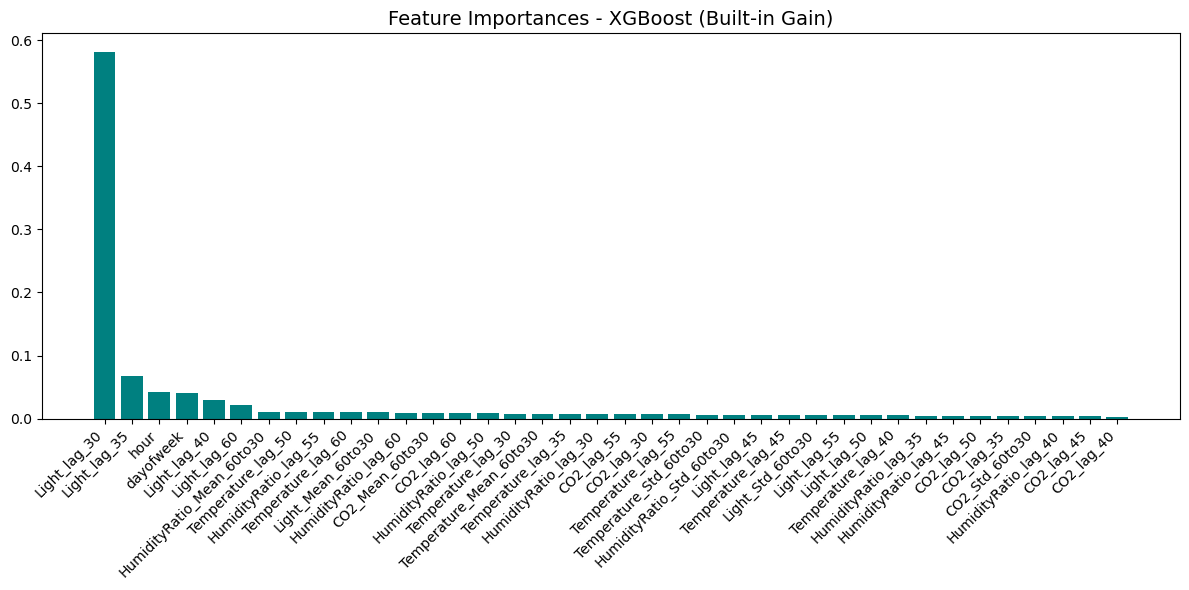


2. Global: Permutation Importance (on Test Set)


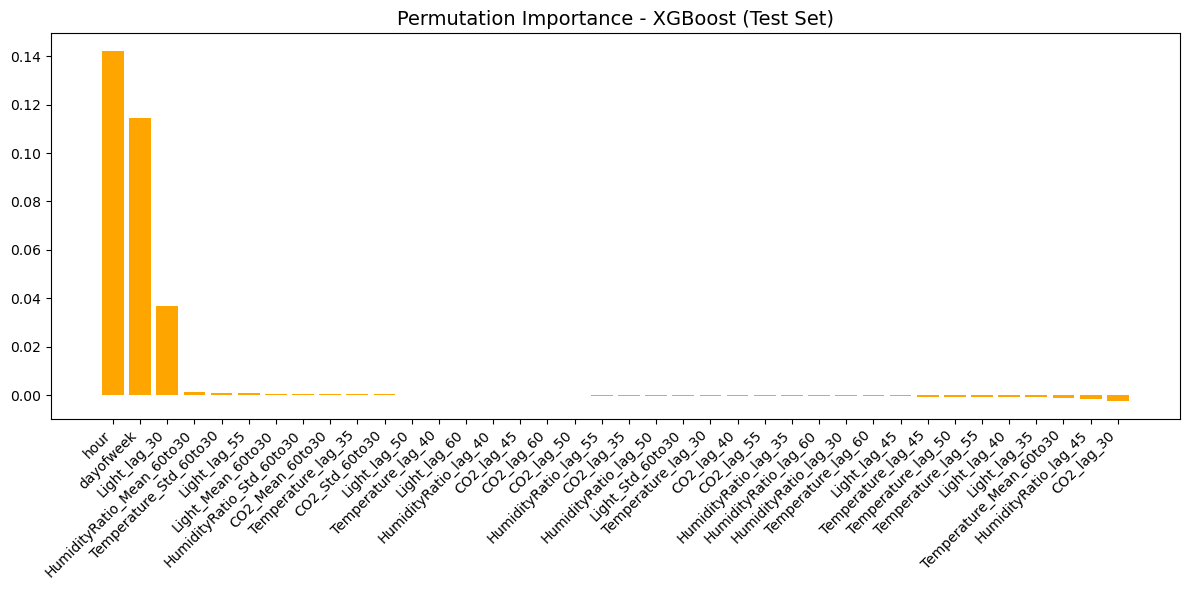


3. SHAP Analysis (XGBoost)
Global SHAP Summary Plot (Bar):


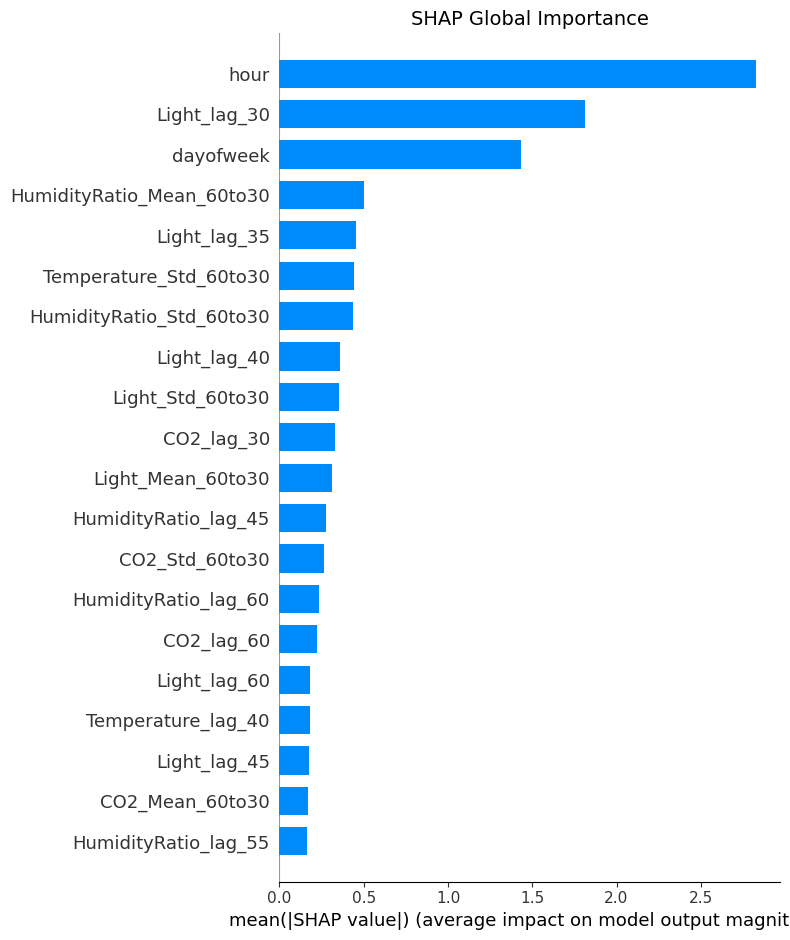

Global SHAP Beeswarm Plot:


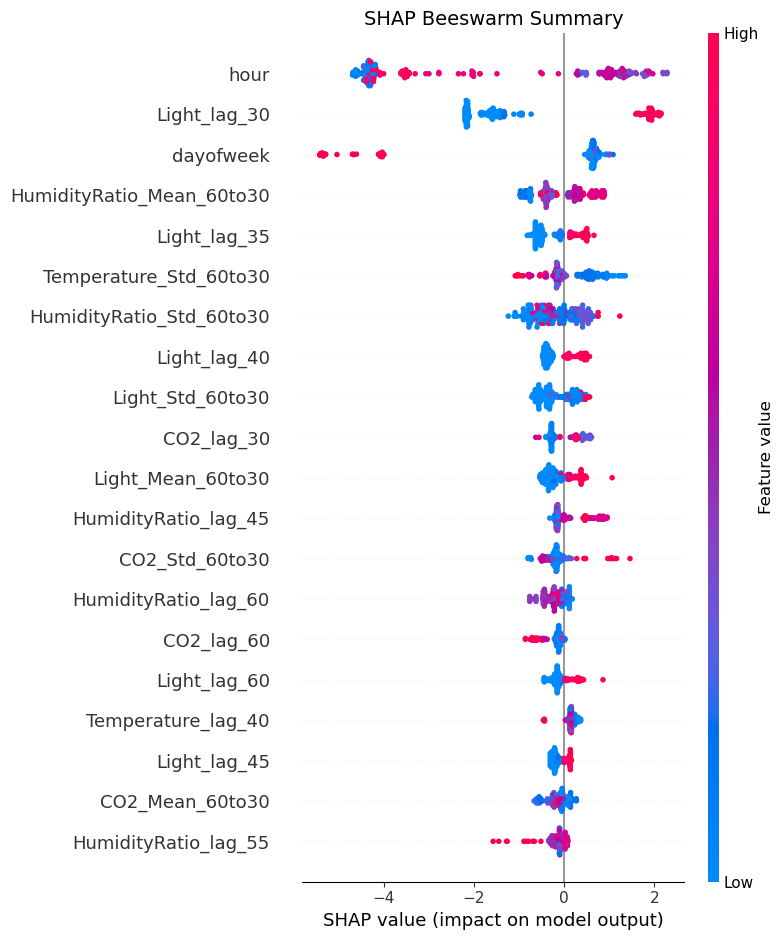

Local SHAP Waterfall for Sample #4 (True Label: Occupied):


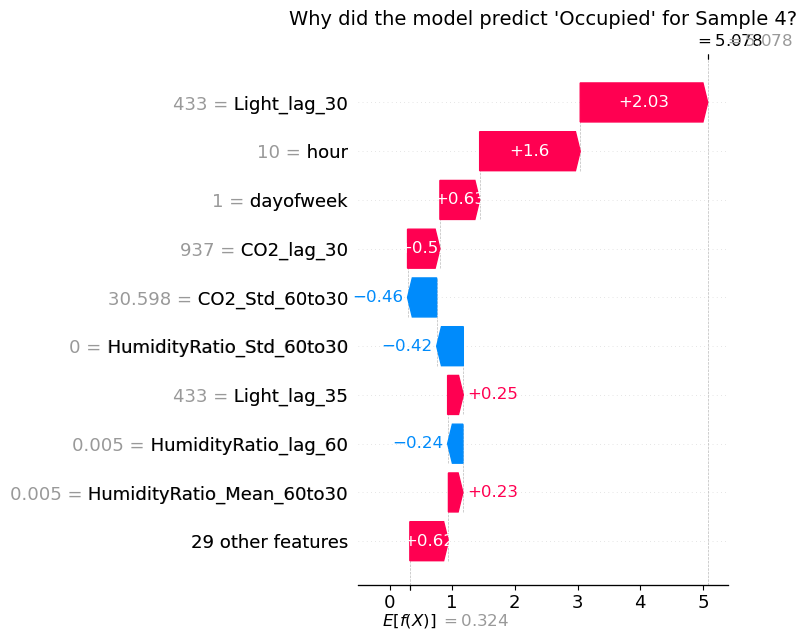

In [20]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

print("\nAdvanced Feature Importance & SHAP")
champion_model = final_xgb
champion_name = "XGBoost"
print(f"Analyzing Champion Model: {champion_name}")

print(f"\n1. Global: Built-in Feature Importance ({champion_name})")
importances = champion_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title(f"Feature Importances - {champion_name} (Built-in Gain)", fontsize=14)
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color="teal")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\n2. Global: Permutation Importance (on Test Set)")
perm_importance = permutation_importance(champion_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='f1')
perm_sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(12, 6))
plt.title(f"Permutation Importance - {champion_name} (Test Set)", fontsize=14)
plt.bar(range(X_test.shape[1]), perm_importance.importances_mean[perm_sorted_idx], align="center", color="orange")
plt.xticks(range(X_test.shape[1]), X_test.columns[perm_sorted_idx], rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(f"\n3. SHAP Analysis ({champion_name})")

sample_size = 200
if len(X_test) > sample_size:
    X_test_sample = X_test.sample(n=sample_size, random_state=42)
else:
    X_test_sample = X_test

y_test_sample = y_test.loc[X_test_sample.index]

explainer = shap.TreeExplainer(champion_model)
shap_values = explainer.shap_values(X_test_sample)

if isinstance(shap_values, list):
    shap_values_target = shap_values[1]
    base_value = explainer.expected_value[1]
elif len(np.array(shap_values).shape) == 3:
    shap_values_target = shap_values[:, :, 1]
    base_value = explainer.expected_value[1]
else:
    shap_values_target = shap_values
    base_value = explainer.expected_value

print("Global SHAP Summary Plot (Bar):")
plt.figure()
shap.summary_plot(shap_values_target, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Global Importance", fontsize=14)
plt.tight_layout()
plt.show()

print("Global SHAP Beeswarm Plot:")
plt.figure()
shap.summary_plot(shap_values_target, X_test_sample, show=False)
plt.title("SHAP Beeswarm Summary", fontsize=14)
plt.tight_layout()
plt.show()

occupied_indices = np.where(y_test_sample == 1)[0]

if len(occupied_indices) > 0:
    idx = occupied_indices[0]
    print(f"Local SHAP Waterfall for Sample #{idx} (True Label: Occupied):")
    shap_exp = shap.Explanation(values=shap_values_target[idx],
                                base_values=base_value,
                                data=X_test_sample.iloc[idx],
                                feature_names=X_test_sample.columns)
    
    plt.figure()
    shap.plots.waterfall(shap_exp, show=False)
    plt.title(f"Why did the model predict 'Occupied' for Sample {idx}?", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No positive samples found in the random subset for waterfall plot.")

,Model,Test F1,CV Mean,CV Std,Recall
0,Random Forest,0.9355,0.6774,0.3381,0.9590
1,XGBoost,0.9346,0.6938,0.3447,0.9708
2,KNN,0.9115,0.5746,0.3092,0.9253
3,LogReg (L2),0.8898,0.7146,0.3027,0.9389
4,LogReg (ElasticNet),0.8882,0.7150,0.3032,0.9380
5,LogReg (L1),0.8787,0.7121,0.2997,0.9344
6,SVM (RBF),0.8466,0.6286,0.3233,0.9435
7,Baseline,0.4241,0.2945,0.2180,1.0000


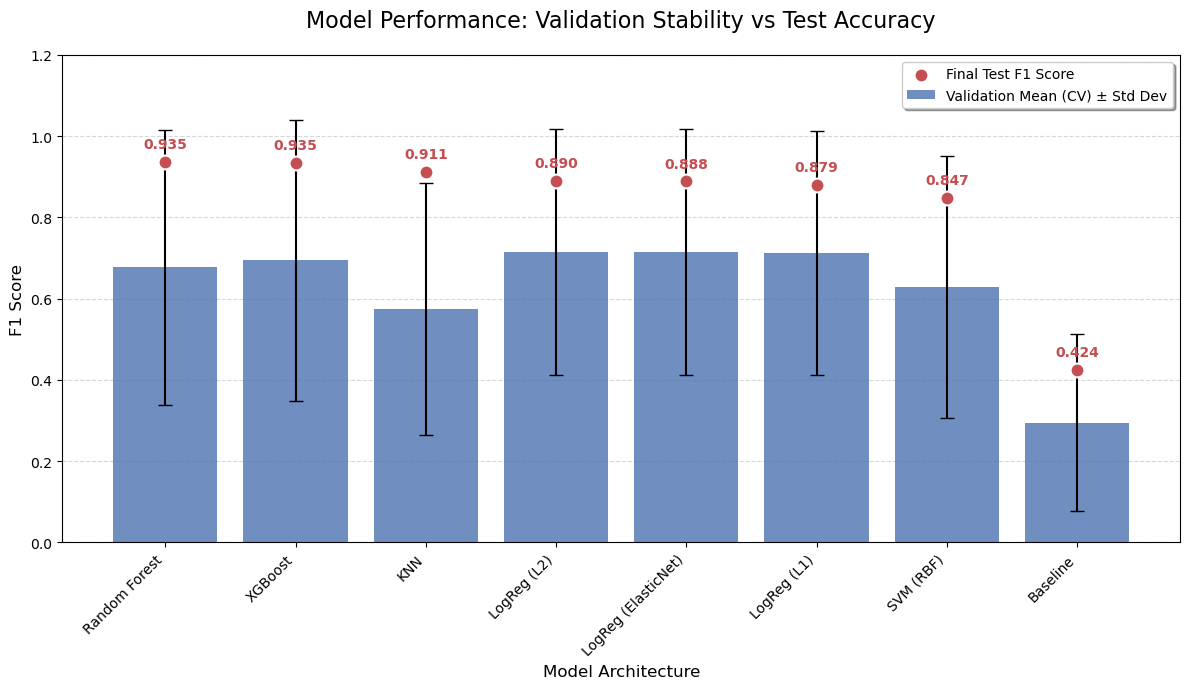

In [21]:
results_data = [
    {
        "Model": "Random Forest",
        "Test F1": 0.9355,
        "CV Mean": 0.6774,
        "CV Std": 0.3381,
        "Recall": 0.9590,
    },
    {
        "Model": "XGBoost",
        "Test F1": 0.9346,
        "CV Mean": 0.6938,
        "CV Std": 0.3447,
        "Recall": 0.9708,
    },
    {
        "Model": "KNN",
        "Test F1": 0.9115,
        "CV Mean": 0.5746,
        "CV Std": 0.3092,
        "Recall": 0.9253,
    },
    {
        "Model": "LogReg (L2)",
        "Test F1": 0.8898,
        "CV Mean": 0.7146,
        "CV Std": 0.3027,
        "Recall": 0.9389,
    },
    {
        "Model": "LogReg (ElasticNet)",
        "Test F1": 0.8882,
        "CV Mean": 0.7150,
        "CV Std": 0.3032,
        "Recall": 0.9380,
    },
    {
        "Model": "LogReg (L1)",
        "Test F1": 0.8787,
        "CV Mean": 0.7121,
        "CV Std": 0.2997,
        "Recall": 0.9344,
    },
    {
        "Model": "SVM (RBF)",
        "Test F1": 0.8466,
        "CV Mean": 0.6286,
        "CV Std": 0.3233,
        "Recall": 0.9435,
    },
    {
        "Model": "Baseline",
        "Test F1": 0.4241,
        "CV Mean": 0.2945,
        "CV Std": 0.2180,
        "Recall": 1.0000,
    },
]

df_res = pd.DataFrame(results_data)
df_res = df_res.sort_values(by="Test F1", ascending=False).reset_index(drop=True)

pd.set_option("display.precision", 4)
display(df_res)

plt.figure(figsize=(12, 7))

bar_color = '#4c72b0'
point_color = '#c44e52'

bars = plt.bar(
    df_res["Model"],
    df_res["CV Mean"],
    yerr=df_res["CV Std"],
    capsize=5,
    color=bar_color,
    alpha=0.8,
    label="Validation Mean (CV) ± Std Dev",
    zorder=2,
)

scatter = plt.scatter(
    df_res["Model"],
    df_res["Test F1"],
    color=point_color,
    marker="o",
    s=100,
    label="Final Test F1 Score",
    zorder=5,
    edgecolors="white",
    linewidth=1.5,
)

for i, txt in enumerate(df_res["Test F1"]):
    if txt > 0.01:
        plt.annotate(
            f"{txt:.3f}",
            (i, txt),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            fontsize=10,
            fontweight="bold",
            color=point_color,
        )

best_model_idx = 0


plt.title("Model Performance: Validation Stability vs Test Accuracy", fontsize=16, pad=20)
plt.ylabel("F1 Score", fontsize=12)
plt.xlabel("Model Architecture", fontsize=12)
plt.ylim(0, 1.2)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.legend(loc="upper right", frameon=True, fancybox=True, shadow=True, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)
plt.tight_layout()

if not os.path.exists("figures"):
    os.makedirs("figures")
plt.show()

In [23]:
if 'df_res' in locals():
    df_res.to_csv("../results/model_performance_summary.csv", index=False)
    print("Model performance summary saved to results/model_performance_summary.csv")
else:
    print("df_res not found, skipping save.")

Model performance summary saved to results/model_performance_summary.csv


In [24]:
import joblib

if 'final_xgb' in locals():
    joblib.dump(final_xgb, "../results/final_xgboost_model.pkl")
    print("Final XGBoost model saved to results/final_xgboost_model.pkl")

Final XGBoost model saved to results/final_xgboost_model.pkl
